## Vector Autoregression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(3)

In [2]:
with open("./data/heat_data.pkl", "rb") as f:
    loaded_heat_data = pickle.load(f)
    
with open("./data/elec_data.pkl", "rb") as f:
    loaded_elec_data = pickle.load(f)

In [3]:
import math

def test_train_validate_split(df: pd.DataFrame, percentages=(0.70,0.10,0.20)):
    return np.split(df, [int(percentages[0] * len(df)), int((percentages[0] + percentages[1]) * len(df))])

In [4]:
df_elec_data = pd.concat([loaded_elec_data["df_elec_train"], loaded_elec_data["df_elec_validate"], loaded_elec_data["df_elec_test"]])
df_elec_data = df_elec_data.resample("W").mean()

df_elec_train, df_elec_validate, df_elec_test = test_train_validate_split(df_elec_data)
df_elec_test.shape

/home/ivan/anaconda3/envs/weather-prediction/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


(84, 4)

### Sanity Check

In [40]:
assert loaded_heat_data["df_heat_train"].shape == (49056, 6)
assert loaded_heat_data["df_heat_test"].shape == (14017, 6)
assert loaded_heat_data["df_heat_validate"].shape == (7007, 6)

assert loaded_elec_data["df_elec_train"].shape == (49056, 4)
assert loaded_elec_data["df_elec_test"].shape == (14017, 4)
assert loaded_elec_data["df_elec_validate"].shape == (7007, 4)


In [41]:
def display_time_series(df_train, df_validate, df_test, col="", figsize=(15,5), title="", ):
    ax = df_train[col].plot(figsize=figsize, color="tab:blue", label="Train")
    _ = df_test[col].plot(ax=ax, color="tab:red", label="Test")
    _ = df_validate[col].plot(ax=ax, color="tab:orange", label="Validate")
    
    ax.legend()
    ax.axvline(df_validate.index[0], linestyle=":")
    ax.axvline(df_test.index[0], linestyle=":")
    
    plt.title(title)
    plt.show()

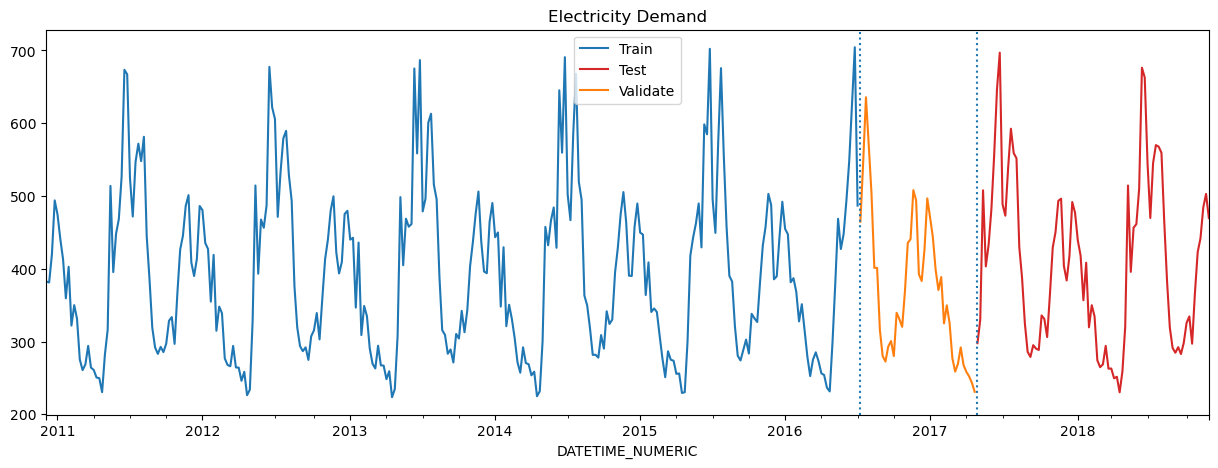

In [42]:
# display_time_series(df_heat_train, df_heat_validate, df_heat_test, col="heat_demand_values[kw]", title="Heat Demand")
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")

## Predicting Electricity Demand

In [8]:
print(f"Train Period: {df_elec_train.index.min()}      ===> {df_elec_train.index.max()} shape: {df_elec_train.shape}")
print(f"Validation Period: {df_elec_validate.index.min()} ===> {df_elec_validate.index.max()} shape: {df_elec_validate.shape}")
print(f"Test Period: {df_elec_test.index.min()}       ===> {df_elec_test.index.max()} shape: {df_elec_test.shape}")


Train Period: 2010-12-05 00:00:00      ===> 2016-07-03 00:00:00 shape: (292, 4)
Validation Period: 2016-07-10 00:00:00 ===> 2017-04-23 00:00:00 shape: (42, 4)
Test Period: 2017-04-30 00:00:00       ===> 2018-12-02 00:00:00 shape: (84, 4)


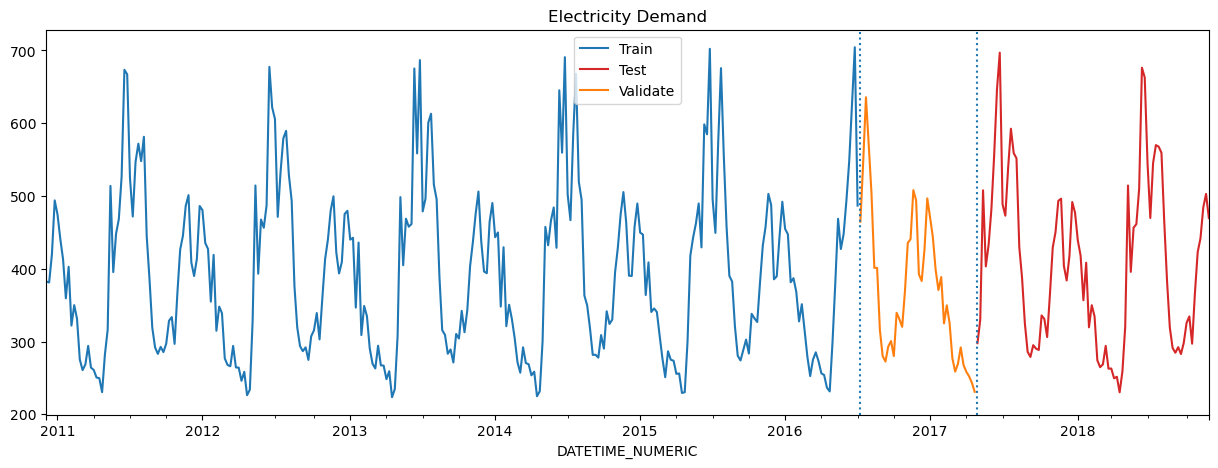

In [9]:
display_time_series(df_elec_train, df_elec_validate, df_elec_test, col="electricity_demand_values[kw]", title="Electricity Demand")


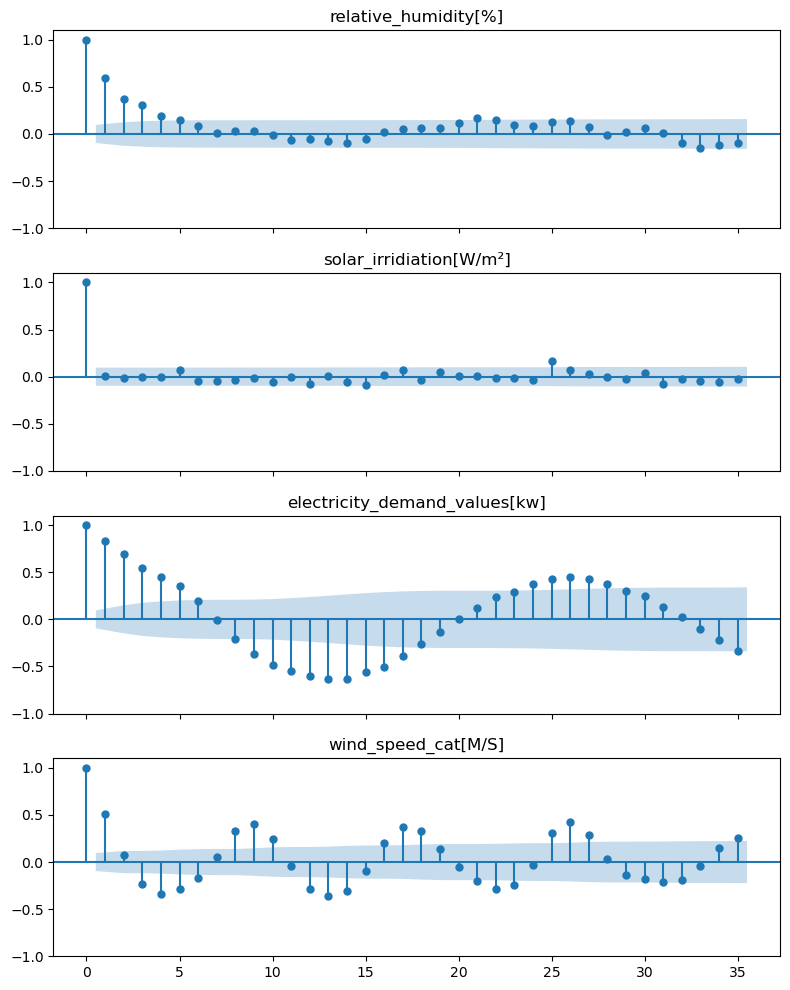

In [39]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 10), sharex=True)
axes = axes.flat
for i, col in enumerate(df_elec_data.columns):
    plot_acf(df_elec_data[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.show()

## Modelling a multi-variate Timeseries

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate

In [12]:
df_elec_data.head()

,relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S]
DATETIME_NUMERIC,,,,
2010-12-05,64.516667,262.116667,382.724679,5.391667
2010-12-12,63.988095,276.958333,381.154926,5.273810
2010-12-19,73.166667,267.613095,419.930448,5.119048
2010-12-26,68.779762,258.523810,493.969037,5.279762
2011-01-02,69.196429,245.309524,474.827742,4.702381


In [13]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoregMultiVariate(
    regressor         = RandomForestRegressor(random_state=42),
    lags              = 72,
    transformer_series= StandardScaler(),
    level             = "electricity_demand_values[kw]",
    steps             = 10
)

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_elec_data,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(df_elec_train) + len(df_elec_validate),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True )

  0%|          | 0/12 [00:00<?, ?it/s]

In [14]:
print("Backtest metrics")
display(multi_series_mae)
print("")
print("Backtest predictions")
predictions_ms.head(4)

Backtest metrics


,levels,mean_absolute_error
0,electricity_demand_values[kw],16.528286



Backtest predictions


,electricity_demand_values[kw]
2017-04-30,292.860630
2017-05-07,387.273162
2017-05-14,460.088242
2017-05-21,445.718995


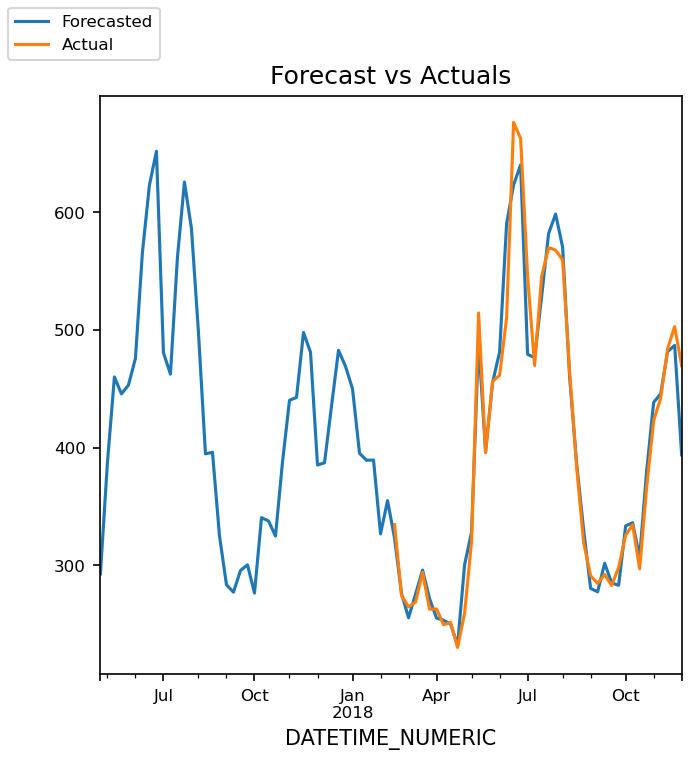

In [92]:
# plotting forecast vs actuals
fig = plt.figure(dpi=150, figsize=(5,5))
predictions_ms["electricity_demand_values[kw]"].plot(label="Forecasted")
df_elec_test["electricity_demand_values[kw]"][-len(df_elec_validate):].plot(label="Actual", fontsize=8)
plt.title("Forecast vs Actuals", fontsize=12)
fig.legend(loc='upper left', fontsize=8)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [35]:
df_elec_data.head()

,relative_humidity[%],solar_irridiation[W/m²],electricity_demand_values[kw],wind_speed_cat[M/S]
DATETIME_NUMERIC,,,,
2010-12-05,64.516667,262.116667,382.724679,5.391667
2010-12-12,63.988095,276.958333,381.154926,5.273810
2010-12-19,73.166667,267.613095,419.930448,5.119048
2010-12-26,68.779762,258.523810,493.969037,5.279762
2011-01-02,69.196429,245.309524,474.827742,4.702381


In [36]:
items = list(df_elec_data.columns)


forecaster_ms = ForecasterAutoreg(
    regressor         = RandomForestRegressor(random_state=42),
    lags              = 72,
)

single_series_mae, predictions_ss = backtesting_forecaster(
                                       forecaster         = forecaster_ms,
                                       y                  = df_elec_data["electricity_demand_values[kw]"],
                                       steps              = 7,
                                       metric             = 'mean_absolute_percentage_error',
                                       initial_train_size = len(df_elec_train) + len(df_elec_validate),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True )

  0%|          | 0/12 [00:00<?, ?it/s]

In [37]:
print("Backtest metrics")
display(single_series_mae)
print("")
print("Backtest predictions")
predictions_ss.head(4)

Backtest metrics


0.03152470122462893


Backtest predictions


,pred
2017-04-30,293.961347
2017-05-07,385.995552
2017-05-14,452.243991
2017-05-21,449.403108


matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 750x750 with 0 Axes>

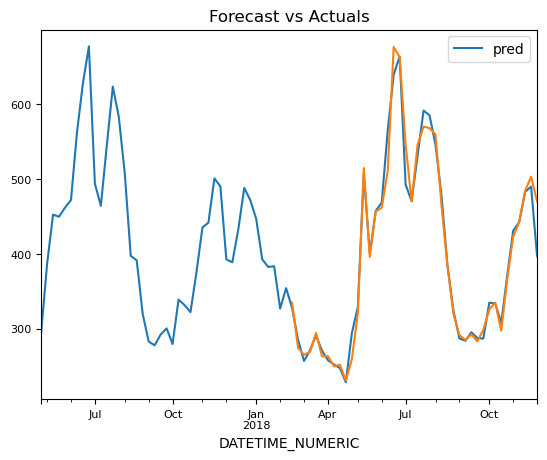

In [38]:
# plotting forecast vs actuals
fig = plt.figure(dpi=150, figsize=(5,5))
predictions_ss.plot(label="Forecasted")
df_elec_test["electricity_demand_values[kw]"][-len(df_elec_validate):].plot(label="Actual", fontsize=8)
plt.title("Forecast vs Actuals", fontsize=12)
fig.legend(loc='upper left', fontsize=8)

In [45]:
from sklearn.utils.discovery import all_estimators
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [61]:
import pmdarima as pm

In [78]:
model = pm.auto_arima(df_elec_data['electricity_demand_values[kw]'], 
                          m=52, 
                          seasonal=True,
                          start_p=0,
                          start_q=0,
                          max_order=4,
                          test='adf',
                          error_action='ignore',  
                          suppress_warnings=True,
                          stepwise=True, 
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=5135.377, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=5.38 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=6216.945, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=3.48 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=4633.456, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.09 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=4635.369, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=4635.388, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=4868.941, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=4637.448, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[52]             : AIC=4667.704, T

In [79]:
model.fit(df_elec_train['electricity_demand_values[kw]'])

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True)

In [85]:
predictions_arima=model.predict(n_periods=100, return_conf_int=True)

In [86]:
predictions_arima

(2016-07-10    470.983117
 2016-07-17    457.843208
 2016-07-24    446.946026
 2016-07-31    437.908782
 2016-08-07    430.414020
                  ...    
 2018-05-06    393.997747
 2018-05-13    393.997747
 2018-05-20    393.997747
 2018-05-27    393.997747
 2018-06-03    393.997747
 Freq: W-SUN, Length: 100, dtype: float64,
 array([[347.30252623, 594.6637071 ],
        [297.16452298, 618.52189251],
        [265.13979994, 628.75225267],
        [242.8956567 , 632.92190787],
        [226.81419446, 634.01384645],
        [214.89732243, 633.49961566],
        [205.90994231, 632.17764098],
        [199.038565  , 630.49927031],
        [193.72552021, 628.7218432 ],
        [189.57783351, 626.98926397],
        [186.31285926, 625.37761958],
        [183.72396818, 623.9222362 ],
        [181.65801939, 622.6341897 ],
        [180.00014125, 621.51053445],
        [178.66322746, 620.54066864],
        [177.58056493, 619.71027409],
        [176.70058774, 619.00371591],
        [175.98309894, 61

In [87]:
forecast_df = pd.DataFrame(predictions_arima[0],index = X_test.index,columns=['Prediction'])

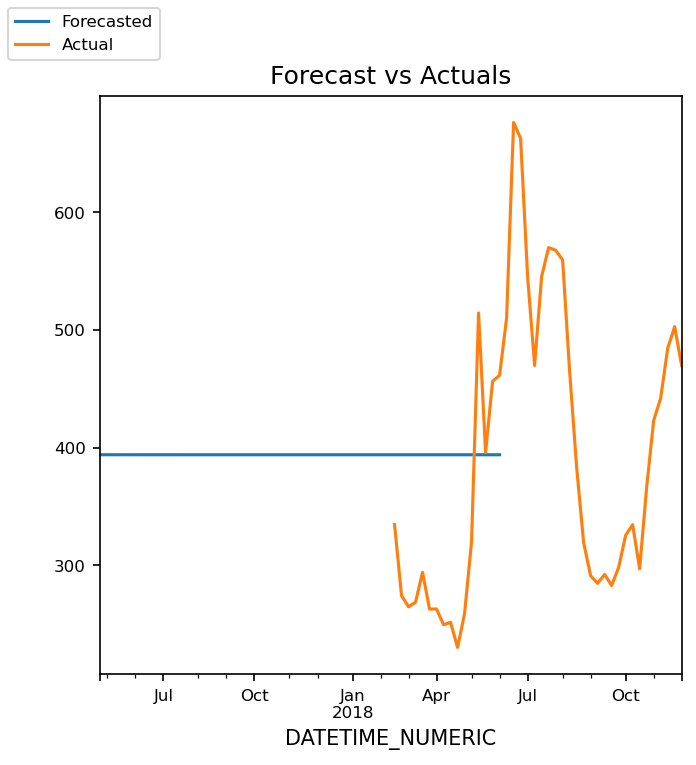

In [90]:
fig = plt.figure(dpi=150, figsize=(5,5))
forecast_df["Prediction"].plot(label="Forecasted")
df_elec_test["electricity_demand_values[kw]"][-len(df_elec_validate):].plot(label="Actual", fontsize=8)
plt.title("Forecast vs Actuals", fontsize=12)
fig.legend(loc='upper left', fontsize=8)